In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import ta
import shap

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from xgboost import XGBRegressor

In [7]:
df = pd.read_csv('../data/citi_stock_data.csv', header=1, skiprows=[0])
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.rename(columns={df.columns[0]: 'Close_C'}, inplace=True)
df = df[['Close_C']]
df.head()

,Close_C
Date,
2019-01-01,44.022671
2019-01-08,46.650890
2019-01-15,49.967827
2019-01-22,50.545727
2019-01-29,50.711956


In [10]:
# Create lag features
df['lag_1'] = df['Close_C'].shift(1)
df['lag_5'] = df['Close_C'].shift(5)
df['lag_10'] = df['Close_C'].shift(10)

# Rolling window stats
df['roll_mean_7'] = df['Close_C'].rolling(window=7).mean()
df['roll_std_7'] = df['Close_C'].rolling(window=7).std()
df['roll_mean_30'] = df['Close_C'].rolling(window=30).mean()

# Target variable: next day's closing price
df['target'] = df['Close_C'].shift(-1)

# Drop rows with NaNs created by shifts/rolls
df_model = df.dropna()

In [11]:
# Define feature columns
features = ['lag_1', 'lag_5', 'lag_10', 'roll_mean_7', 'roll_std_7', 'roll_mean_30']

# Time-based split
train = df_model.loc[:'2023-12-31']
test = df_model.loc['2024-01-01':]

X_train = train[features]
y_train = train['target']
X_test = test[features]
y_test = test['target']

In [23]:
# Create TreeExplainer and calculate SHAP values
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

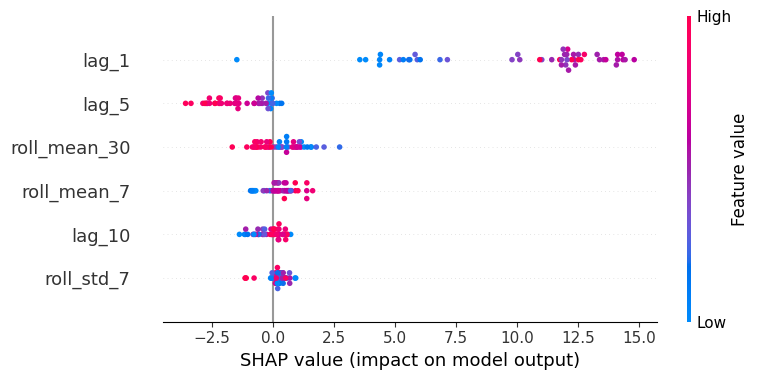

In [24]:
shap.summary_plot(shap_values, X_test)

In [ ]:
model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

<Figure size 1000x600 with 0 Axes>

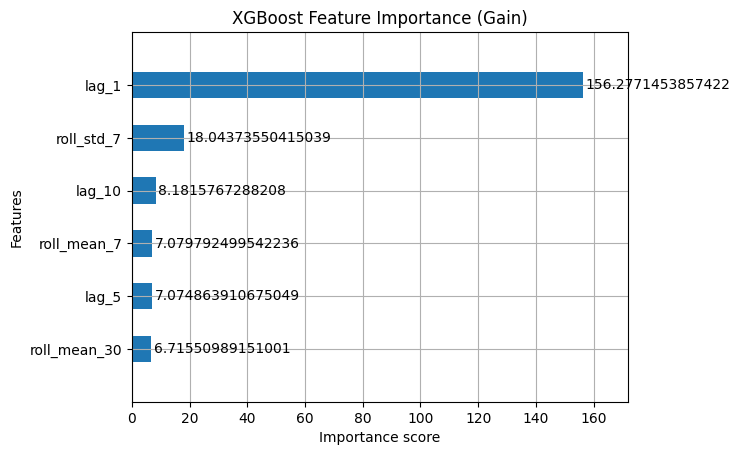

In [15]:
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model, height=0.5, importance_type='gain')  # or 'weight', 'cover'
plt.title("XGBoost Feature Importance (Gain)")
plt.show()

In [19]:
y_pred = model.predict(X_test)

from sklearn.metrics import root_mean_squared_error, mean_absolute_error

rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

RMSE: 5.13
MAE: 3.66
MAPE: 5.83%


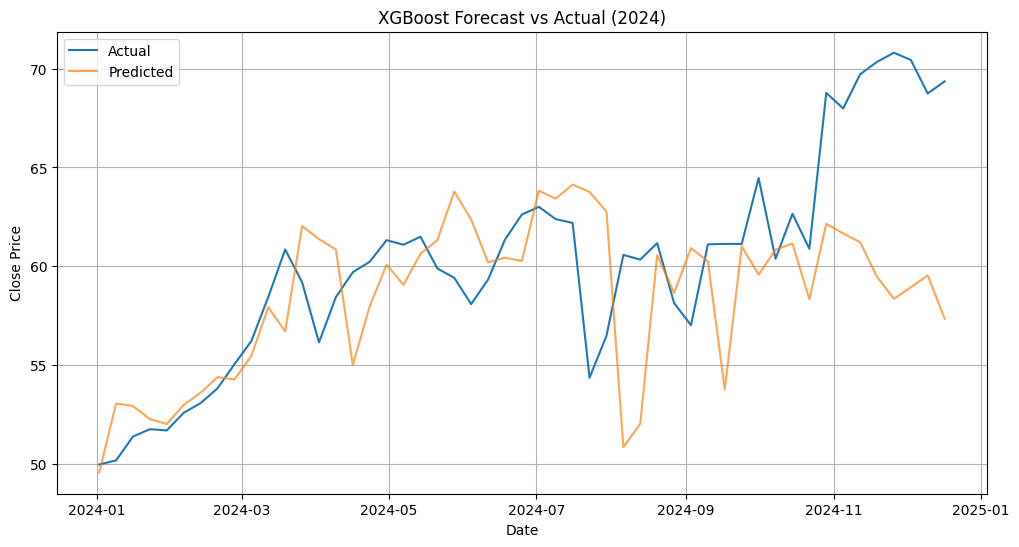

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted', alpha=0.7)
plt.title("XGBoost Forecast vs Actual (2024)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

In [26]:
tscv = TimeSeriesSplit(n_splits=5)
model = XGBRegressor(random_state=42)

scores = cross_val_score(model, X_train, y_train, cv=tscv, scoring='neg_root_mean_squared_error')
print(f"Average RMSE: {-scores.mean():.4f}")

Average RMSE: 5.3127


In [29]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=5)
xgb = XGBRegressor(random_state=42)

grid_search = GridSearchCV(estimator=xgb,
                           param_grid=param_grid,
                           scoring='neg_root_mean_squared_error',
                           cv=tscv,
                           verbose=1,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
print("Best params:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [30]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 4.8250


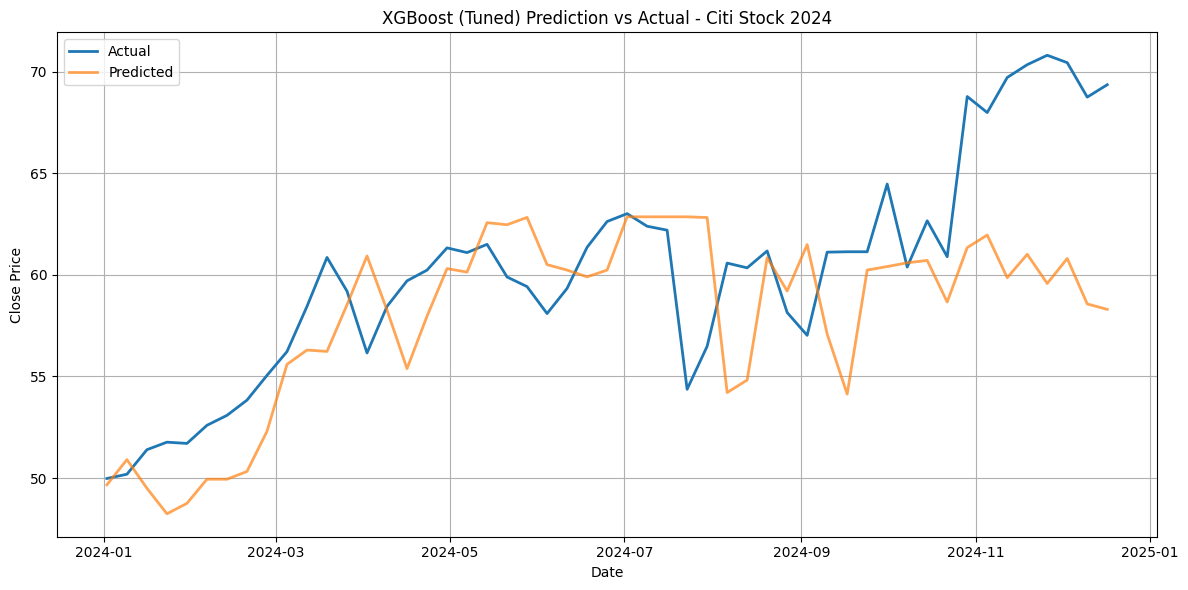

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred, label='Predicted', linewidth=2, alpha=0.7)
plt.title('XGBoost (Tuned) Prediction vs Actual - Citi Stock 2024')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

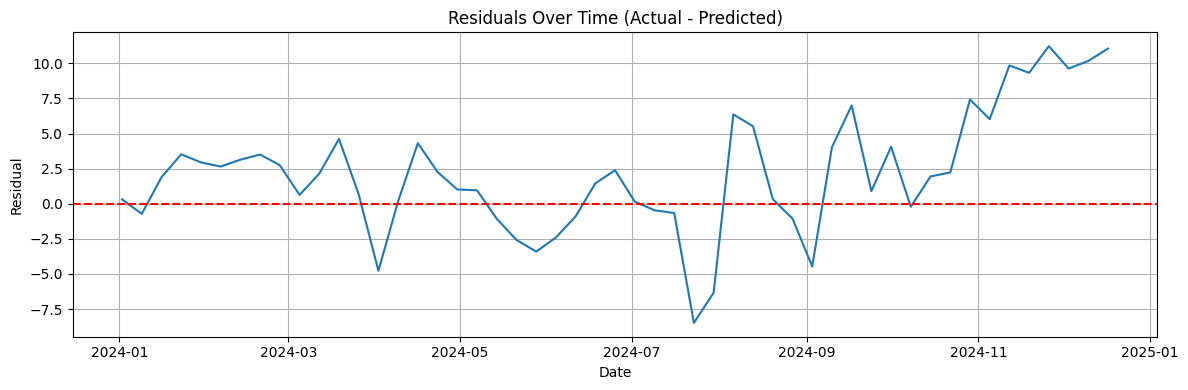

In [32]:
residuals = y_test - y_pred

plt.figure(figsize=(12, 4))
plt.plot(y_test.index, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Over Time (Actual - Predicted)')
plt.xlabel('Date')
plt.ylabel('Residual')
plt.grid(True)
plt.tight_layout()
plt.show()